In [1]:
from utils import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
import pandas as pd

import gym
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

print("Gym version:", gym.__version__)
print("Torch version:", torch.__version__)

Gym version: 0.15.3
Torch version: 1.13.0+cpu


In [2]:
NUM_RUNS = 10 #initially set at 10


#######
#hyper-parameters
NUM_EPISODES=300 #MINIBATCH_SIZE is the number of elements used from ReplayBuffer to train the model in each iteration
MINIBATCH_SIZE = 64 
DQN_architecture =[4,20,2]
replay_buffer_size=50000
target_network_frequency=10
EPSILON = 1 
eps_decay = 0.99
#######




# Question 1.1 

In [3]:
runs_results = []

env = gym.make('CartPole-v1')
list_eps = []#Store epsilon decay to show effect of exploration vs exploitation

for run in range(NUM_RUNS):
    
    print(f"Starting run {run+1} of {NUM_RUNS}")
    
    # *This sets the layer architecture 
    policy_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    target_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    update_target(target_net, policy_net)
    target_net.eval()

    #The optimizer for the DQN training is set as Adam
    optimizer = optim.Adam(policy_net.parameters())
                           
    # *Size of the ReplayBuffer list, to store previous experiences, is set to 5000
    memory = ReplayBuffer(replay_buffer_size)
    steps_done = 0

    #Hyperparameters
    #The following code manages the variables for the epsilon-decay algorithm utilised in this model
    EPSILON = 1 
    eps_decay = 0.99
    
    episode_durations = []

    for i_episode in range(NUM_EPISODES):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", NUM_EPISODES)
        observation = env.reset()
        state = torch.tensor(observation).float()
        list_eps.append(EPSILON)

        if EPSILON>0.1:
            EPSILON = EPSILON * eps_decay #Conducting epsilon-decay on each episode
          
        
        done = False
#         terminated = False
        t = 0
        while not (done):
            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)
            observation, reward, done, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()
            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < MINIBATCH_SIZE: # *remember to change memory batch size
                transitions = memory.sample(MINIBATCH_SIZE)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones,True)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()

            if done:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % target_network_frequency== 0:  #10 is a hyperparameter. Choose how often u want to update your target network
            update_target(target_net, policy_net)
    runs_results.append(episode_durations)
    
print('Complete')

Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

# 1.3 Plotting learning curve

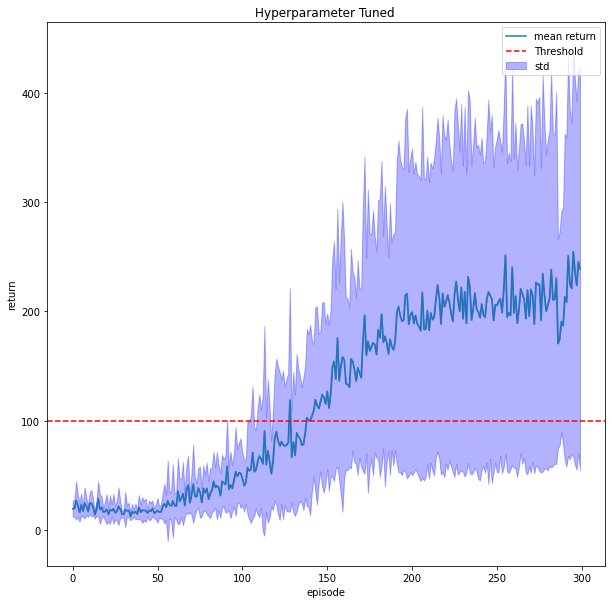

In [5]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize=(10, 10))
plt.plot(torch.arange(NUM_EPISODES), means,label="mean return")
plt.ylabel("return")
plt.xlabel("episode")
plt.axhline(y=100, color='r', linestyle='--',label="Threshold")
plt.title(f'Hyperparameter Tuned ')
plt.fill_between(np.arange(NUM_EPISODES), means, means+stds,alpha=0.3, color='b',label='std')
plt.fill_between(np.arange(NUM_EPISODES), means, means-stds,alpha=0.3, color='b')
plt.legend()

plt.show()

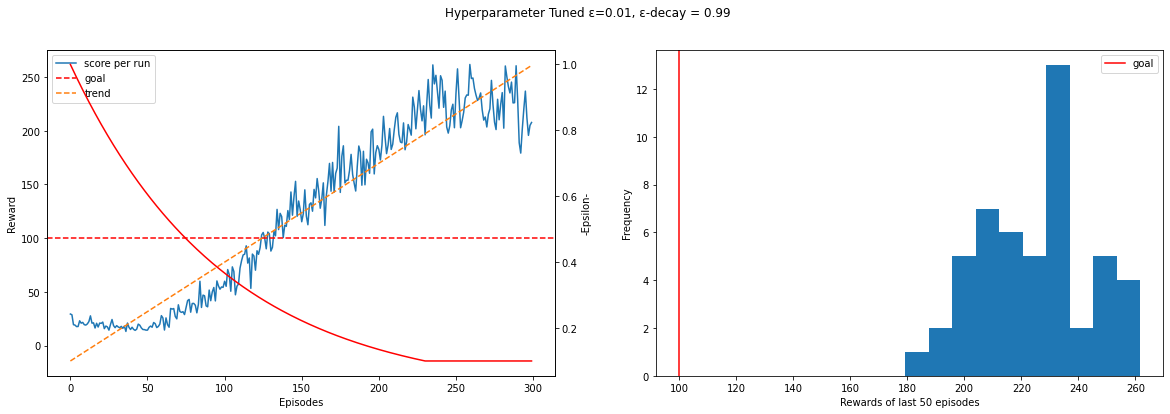

In [243]:
#Create a visulazation of data

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
#     clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(100, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    
    
    ax2 = ax[0].twinx()
    ax2.set_ylabel('-Epsilon-')  # we already handled the x-label with ax1
    ax2.plot(pd.Series(list_eps[:300]), color="r")
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
        ax[0].legend()

    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(100, c='red', label='goal')
    ax[1].set_xlabel('Rewards of last 50 episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()
plot_res(means.tolist(),"Hyperparameter Tuned ε=0.01, ε-decay = 0.99")


#### Plotting epsilon decay rate 

Text(0.5, 1.0, 'Epsilon Decay')

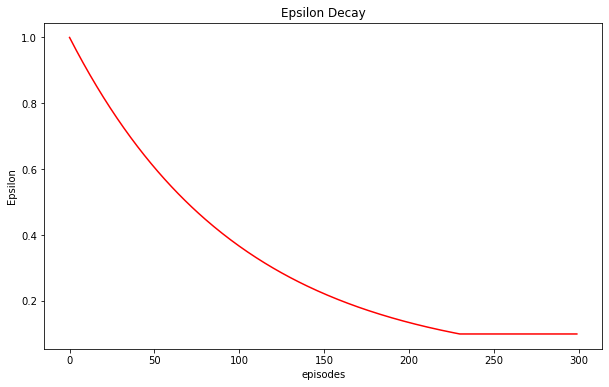

In [244]:
plt.figure(figsize=(10,6))
plt.plot(list_eps[:300],color='red')
plt.xlabel('episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')

### Target network frequency update comparisons

   

In [9]:
NUM_RUNS = 10 #initially set at 10
runs_results_exp= []



#######
#hyper-parameters
NUM_EPISODES=300 #MINIBATCH_SIZE is the number of elements used from ReplayBuffer to train the model in each iteration
MINIBATCH_SIZE = 64 
DQN_architecture =[4,20,2]#[4,20,20,2]
replay_buffer_size=50000
target_network_frequency=10

#######

# uncomment to run cell. takes +-2hrs to complete

env = gym.make('CartPole-v1')
list_eps = []#Store epsilon decay to show effect of exploration vs exploitation
target_network=[1,10,50,200]
runs_results_exp_np=np.zeros((len(target_network),int(NUM_RUNS),int(NUM_EPISODES)))

for tnf in range(len(target_network)):
    for run in range(NUM_RUNS):

        print(f"Starting run {run+1} of {NUM_RUNS}")

        # *This sets the layer architecture 
        policy_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
        target_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
        update_target(target_net, policy_net)
        target_net.eval()

        #The optimizer for the DQN training is set as Adam
        optimizer = optim.Adam(policy_net.parameters())

        # *Size of the ReplayBuffer list, to store previous experiences, is set to 5000
        memory = ReplayBuffer(replay_buffer_size)
        steps_done = 0

        #Hyperparameters
        #The following code manages the variables for the epsilon-decay algorithm utilised in this model
        EPSILON = 1 #Was set to 0.3
        eps_decay = 0.99

        episode_durations = []

        for i_episode in range(NUM_EPISODES):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", NUM_EPISODES)
            observation = env.reset()
            state = torch.tensor(observation).float()
            list_eps.append(EPSILON)

            if EPSILON>0.1:
                EPSILON = EPSILON * eps_decay #Conducting epsilon-decay on each episode
                
            done = False
    #         terminated = False
            t = 0
            while not (done):
                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)
                observation, reward, done, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()
                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < MINIBATCH_SIZE: # *remember to change memory batch size
                    transitions = memory.sample(MINIBATCH_SIZE)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones,True)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()

                if done:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % target_network[tnf]== 0:  #10 is a hyperparameter. Choose how often u want to update your target network
                update_target(target_net, policy_net)
        runs_results_exp_np[tnf][run][:]=episode_durations
print('Complete')    



Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

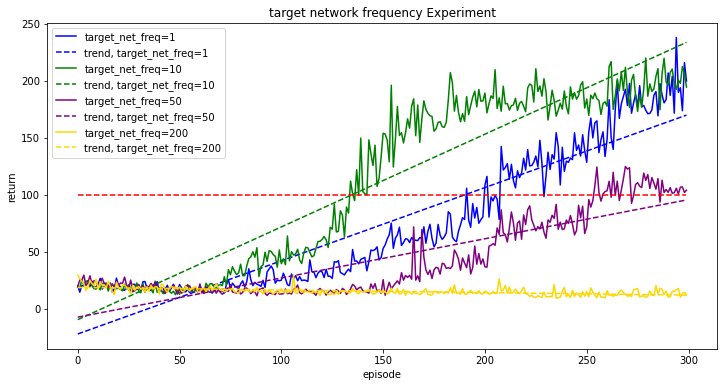

In [10]:
#Print results for ideal target network

color_list=['blue','green','purple','gold']
plt.figure(figsize=(12, 6))
x=torch.arange(300)

for y in range(0,4,1):
    plt.plot(x, runs_results_exp_np[y].mean(axis=0),label=f'target_net_freq={target_network[y]}',color=color_list[y])
    z = np.polyfit(x, runs_results_exp_np[y].mean(axis=0), 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"--", label=f'trend, target_net_freq={target_network[y]}',color=color_list[y])
    plt.legend()
plt.ylabel("return")
plt.xlabel("episode")
plt.title("target network frequency Experiment")

plt.plot(x, len(x)*[100], '--', color='red')

# plt.legend(epsilon_list)
plt.show()

Target network update of 10 produces the best results

# Question 1.2 

# Exploration vs Explotation

In [70]:
NUM_RUNS = 10 #initially set at 10
runs_results_exp= []



#######
#hyper-parameters
NUM_EPISODES=300 #MINIBATCH_SIZE is the number of elements used from ReplayBuffer to train the model in each iteration
MINIBATCH_SIZE = 64 
DQN_architecture =[4,20,20,2]
replay_buffer_size=20000
#######

# uncomment to run cell. takes +-2hrs to complete

env = gym.make('CartPole-v1')
list_eps = []#Store epsilon decay to show effect of exploration vs exploitation
epsilon_list=[0.01,0.3,0.6,1]
runs_results_exp_np=np.zeros((len(epsilon_list),int(NUM_RUNS),int(NUM_EPISODES)))

for exp in range(len(epsilon_list)):
    for run in range(NUM_RUNS):

        print(f"Starting run {run+1} of {NUM_RUNS}")

        # *This sets the layer architecture 
        policy_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
        target_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
        update_target(target_net, policy_net)
        target_net.eval()

        #The optimizer for the DQN training is set as Adam
        optimizer = optim.Adam(policy_net.parameters())

        # *Size of the ReplayBuffer list, to store previous experiences, is set to 5000
        memory = ReplayBuffer(replay_buffer_size)
        steps_done = 0

        #Hyperparameters
        #The following code manages the variables for the epsilon-decay algorithm utilised in this model
        EPSILON = 1 #Was set to 0.3
        eps_decay = 0.99

        episode_durations = []

        for i_episode in range(NUM_EPISODES):
            if (i_episode+1) % 50 == 0:
                print("episode ", i_episode+1, "/", NUM_EPISODES)
            observation = env.reset()
            state = torch.tensor(observation).float()
            list_eps.append(EPSILON)

            if EPSILON>0.1:
                EPSILON = EPSILON * eps_decay #Conducting epsilon-decay on each episode


            done = False
    #         terminated = False
            t = 0
            while not (done):
                # Select and perform an action
                action = epsilon_greedy(EPSILON, policy_net, state)
                observation, reward, done, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()
                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < MINIBATCH_SIZE: # *remember to change memory batch size
                    transitions = memory.sample(MINIBATCH_SIZE)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones,True)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()

                if done:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % target_network_frequency== 0:  #10 is a hyperparameter. Choose how often u want to update your target network
                update_target(target_net, policy_net)
#         runs_results.append(episode_durations)
        runs_results_exp_np[exp][run][:]=episode_durations
print('Complete')    



Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

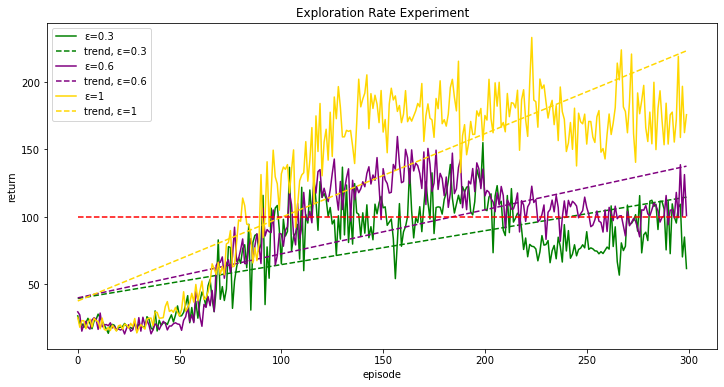

In [73]:
color_list=['blue','green','purple','gold']
plt.figure(figsize=(12, 6))
x=torch.arange(300)

for y in range(1,4,1):
    plt.plot(x, runs_results_exp_np[y].mean(axis=0),label=f'ε={epsilon_list[y]}',color=color_list[y])
    z = np.polyfit(x, runs_results_exp_np[y].mean(axis=0), 1)
    p = np.poly1d(z)
    plt.plot(x,p(x),"--", label=f'trend, ε={epsilon_list[y]}',color=color_list[y])
    plt.legend()
plt.ylabel("return")
plt.xlabel("episode")
plt.title("Exploration Rate Experiment")

plt.plot(x, len(x)*[100], '--', color='red')

# plt.legend(epsilon_list)
plt.show()

Epislon of 1 produces the best results

# Question 2

# Question 2.1.

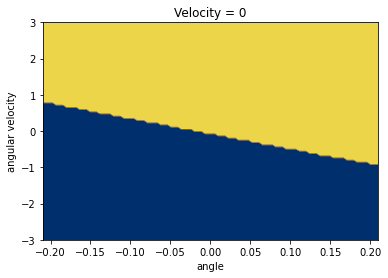

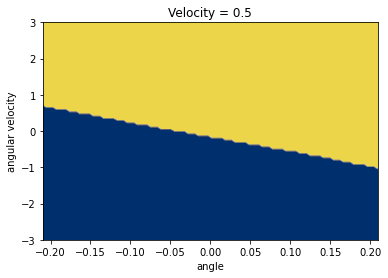

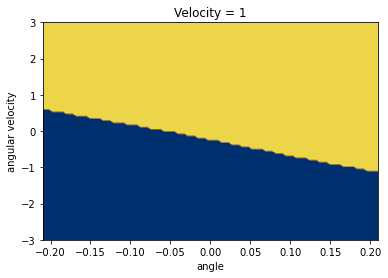

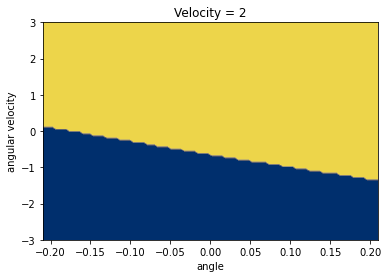

In [202]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = policy_net#DQN(DQN_architecture)   # randomly initialised, replace with your trained DQN
q = False    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 3     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

for car_velocity in [0,0.5,1,2]:
    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., car_velocity, angle, omega]) #[_,cart velocity,_,_]
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
    else:
        plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
    plt.title(f'Velocity = {car_velocity}')
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.show()

## Question 2.2

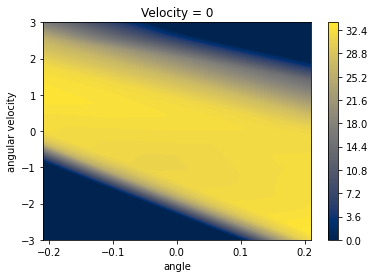

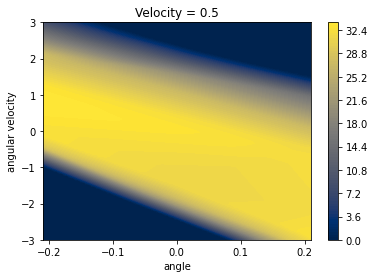

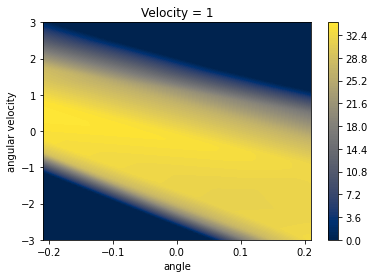

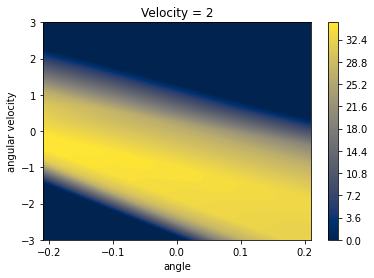

In [76]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = policy_net#DQN(DQN_architecture)   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 3     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)
for car_velocity in [0,0.5,1,2]:

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., car_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plot=plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.colorbar(plot)

    else:
        plot=plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        plt.colorbar(plot)
    plt.title(f'Velocity = {car_velocity}')
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.show()

# Question 3

In [40]:
# from utils_ddqn import DQN, ReplayBuffer, greedy_action, epsilon_greedy, update_target, loss_ddqn


In [44]:
NUM_RUNS = 10 #initially set at 10
runs_results_ddqn = []


#######
#hyper-parameters
NUM_EPISODES=300 #MINIBATCH_SIZE is the number of elements used from ReplayBuffer to train the model in each iteration
MINIBATCH_SIZE = 64 
DQN_architecture =[4,20,2]#[4,20,20,2]
replay_buffer_size=50000
target_network_frequency=10

#######


env = gym.make('CartPole-v1')
list_eps = []#Store epsilon decay to show effect of exploration vs exploitation

for run in range(NUM_RUNS):
    
    print(f"Starting run {run+1} of {NUM_RUNS}")
    
    # *This sets the layer architecture 
    policy_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    target_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    update_target(target_net, policy_net)
    target_net.eval()

    #The optimizer for the DQN training is set as Adam
    optimizer = optim.Adam(policy_net.parameters())
                           
    # *Size of the ReplayBuffer list, to store previous experiences, is set to 50000
    memory = ReplayBuffer(replay_buffer_size)
    steps_done = 0

    #Hyperparameters
    #The following code manages the variables for the epsilon-decay algorithm utilised in this model
    EPSILON = 1 #Was set to 0.3
    eps_decay = 0.99
    
    episode_durations = []

    for i_episode in range(NUM_EPISODES):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", NUM_EPISODES)
        observation = env.reset()
        state = torch.tensor(observation).float()
        list_eps.append(EPSILON)

        if EPSILON>0.1:
            EPSILON = EPSILON * eps_decay #Conducting epsilon-decay on each episode
          
        
        done = False
#         terminated = False
        t = 0
        while not (done):
            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)
            observation, reward, done, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()
            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < MINIBATCH_SIZE: # *remember to change memory batch size
                transitions = memory.sample(MINIBATCH_SIZE)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones,False)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()

            if done:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % target_network_frequency== 0:  #10 is a hyperparameter. Choose how often u want to update your target network
            update_target(target_net, policy_net)
    runs_results_ddqn.append(episode_durations)
    
print('Complete')

Starting run 1 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 5
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Complete


### Plotting DQN vs DDQN

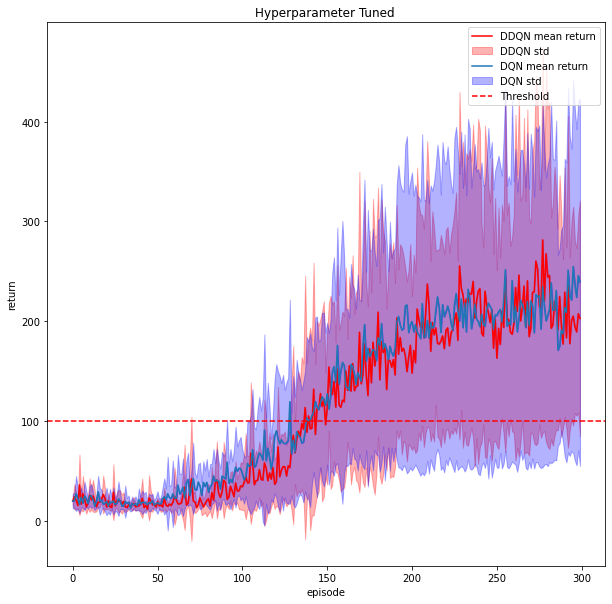

In [54]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results_ddqn = torch.tensor(runs_results_ddqn)
means_ddqn = results_ddqn.float().mean(0)
stds_ddqn = results_ddqn.float().std(0)

plt.figure(figsize=(10, 10))
plt.plot(torch.arange(NUM_EPISODES), means_ddqn,label="DDQN mean return",color='red')


plt.fill_between(np.arange(NUM_EPISODES), means_ddqn, means_ddqn+stds_ddqn,alpha=0.3, color='red',label='DDQN std')
plt.fill_between(np.arange(NUM_EPISODES), means_ddqn, means_ddqn-stds_ddqn,alpha=0.3, color='red')

plt.plot(torch.arange(NUM_EPISODES), means,label="DQN mean return")
plt.fill_between(np.arange(NUM_EPISODES), means, means+stds,alpha=0.3, color='b',label='DQN std')
plt.fill_between(np.arange(NUM_EPISODES), means, means-stds,alpha=0.3, color='b')


plt.ylabel("return")
plt.xlabel("episode")
plt.axhline(y=100, color='r', linestyle='--',label="Threshold")
plt.title(f'Hyperparameter Tuned ')

plt.legend()

plt.show()

# Running DDQN and DQN over longer episode run

In [64]:
# Run DQn over longer episodes
NUM_RUNS = 10 #initially set at 10
runs_results = []


#######
#hyper-parameters
NUM_EPISODES=600 #MINIBATCH_SIZE is the number of elements used from ReplayBuffer to train the model in each iteration
MINIBATCH_SIZE = 64 
DQN_architecture =[4,20,2]#[4,20,20,2]
replay_buffer_size=50000
target_network_frequency=10

#######


env = gym.make('CartPole-v1')
list_eps = []#Store epsilon decay to show effect of exploration vs exploitation

for run in range(NUM_RUNS):
    
    print(f"Starting run {run+1} of {NUM_RUNS}")
    
    # *This sets the layer architecture 
    policy_net_dqn = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    target_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    update_target(target_net, policy_net_dqn)
    target_net.eval()

    #The optimizer for the DQN training is set as Adam
    optimizer = optim.Adam(policy_net_dqn.parameters())
                           
    # *Size of the ReplayBuffer list, to store previous experiences, is set to 5000
    memory = ReplayBuffer(replay_buffer_size)
    steps_done = 0

    #Hyperparameters
    #The following code manages the variables for the epsilon-decay algorithm utilised in this model
    EPSILON = 1 #Was set to 0.3
    eps_decay = 0.99
    
    episode_durations = []

    for i_episode in range(NUM_EPISODES):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", NUM_EPISODES)
        observation = env.reset()
        state = torch.tensor(observation).float()
        list_eps.append(EPSILON)

        if EPSILON>0.1:
            EPSILON = EPSILON * eps_decay #Conducting epsilon-decay on each episode
          
        
        done = False
#         terminated = False
        t = 0
        while not (done):
            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net_dqn, state)
            observation, reward, done, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()
            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < MINIBATCH_SIZE: # *remember to change memory batch size
                transitions = memory.sample(MINIBATCH_SIZE)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net_dqn, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones,True)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()

            if done:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % target_network_frequency== 0:  #10 is a hyperparameter. Choose how often u want to update your target network
            update_target(target_net, policy_net_dqn)
    runs_results.append(episode_durations)
    
print('Complete')

Starting run 1 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 2 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 3 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 4 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting

In [58]:
# Run DDQN for 600 episodes
NUM_RUNS = 10 #initially set at 10
runs_results_ddqn = []


#######
#hyper-parameters
NUM_EPISODES=600 #MINIBATCH_SIZE is the number of elements used from ReplayBuffer to train the model in each iteration
MINIBATCH_SIZE = 64 
DQN_architecture =[4,20,2]#[4,20,20,2]
replay_buffer_size=50000
target_network_frequency=10

#######


env = gym.make('CartPole-v1')
list_eps = []#Store epsilon decay to show effect of exploration vs exploitation

for run in range(NUM_RUNS):
    
    print(f"Starting run {run+1} of {NUM_RUNS}")
    
    # *This sets the layer architecture 
    policy_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    target_net = DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    update_target(target_net, policy_net)
    target_net.eval()

    #The optimizer for the DQN training is set as Adam
    optimizer = optim.Adam(policy_net.parameters())
                           
    # *Size of the ReplayBuffer list, to store previous experiences, is set to 50000
    memory = ReplayBuffer(replay_buffer_size)
    steps_done = 0

    #Hyperparameters
    #The following code manages the variables for the epsilon-decay algorithm utilised in this model
    EPSILON = 1 #Was set to 0.3
    eps_decay = 0.99
    
    episode_durations = []

    for i_episode in range(NUM_EPISODES):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", NUM_EPISODES)
        observation = env.reset()
        state = torch.tensor(observation).float()
        list_eps.append(EPSILON)

        if EPSILON>0.1:
            EPSILON = EPSILON * eps_decay #Conducting epsilon-decay on each episode
          
        
        done = False
#         terminated = False
        t = 0
        while not (done):
            # Select and perform an action
            action = epsilon_greedy(EPSILON, policy_net, state)
            observation, reward, done, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()
            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

            # Perform one step of the optimization (on the policy network)
            if not len(memory.buffer) < MINIBATCH_SIZE: # *remember to change memory batch size
                transitions = memory.sample(MINIBATCH_SIZE)
                state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                # Compute loss
                mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones,False)
                # Optimize the model
                optimizer.zero_grad()
                mse_loss.backward()
                optimizer.step()

            if done:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
        if i_episode % target_network_frequency== 0:  #10 is a hyperparameter. Choose how often u want to update your target network
            update_target(target_net, policy_net)
    runs_results_ddqn.append(episode_durations)
    
print('Complete')

Starting run 1 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 2 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 3 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting run 4 of 10
episode  50 / 600
episode  100 / 600
episode  150 / 600
episode  200 / 600
episode  250 / 600
episode  300 / 600
episode  350 / 600
episode  400 / 600
episode  450 / 600
episode  500 / 600
episode  550 / 600
episode  600 / 600
Starting

# Plotting Learning curve for DQN vs DDQN over longer run

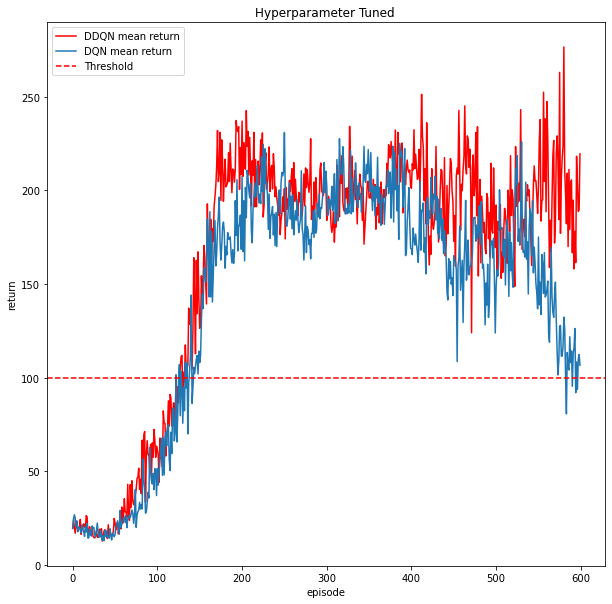

In [66]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results_ddqn = torch.tensor(runs_results_ddqn)
means_ddqn = results_ddqn.float().mean(0)
stds_ddqn = results_ddqn.float().std(0)

results = torch.tensor(runs_results)
means = results.float().mean(0)
stds = results.float().std(0)


plt.figure(figsize=(10, 10))
plt.plot(torch.arange(NUM_EPISODES), means_ddqn,label="DDQN mean return",color='red')
plt.plot(torch.arange(NUM_EPISODES), means,label="DQN mean return")

plt.ylabel("return")
plt.xlabel("episode")
plt.axhline(y=100, color='r', linestyle='--',label="Threshold")
plt.title(f'Hyperparameter Tuned ')

plt.legend()

plt.show()

After several runs, the overestimation bias was evident. After 300 episodes, the DQN rewards begin to decline. This is due to overestimation. The DDQN conversly has a steady state reward performance which shows that there is no overestimation

# Plotting Q plot for DQN

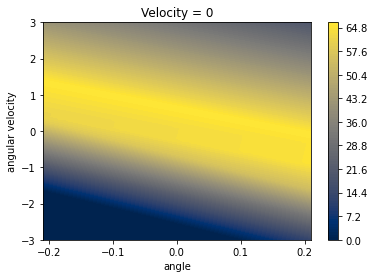

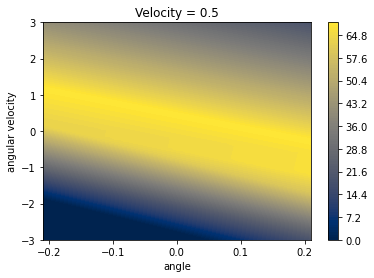

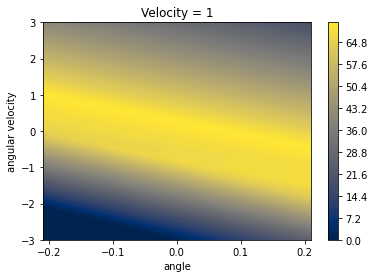

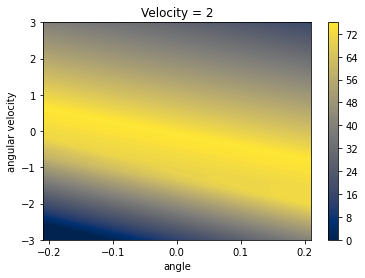

In [68]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = policy_net_dqn#DQN(DQN_architecture)   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 3     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)
for car_velocity in [0,0.5,1,2]:

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., car_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plot=plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.colorbar(plot)

    else:
        plot=plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        plt.colorbar(plot)
    plt.title(f'Velocity = {car_velocity}')
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.show()

# Plotting Q plot for DDQN

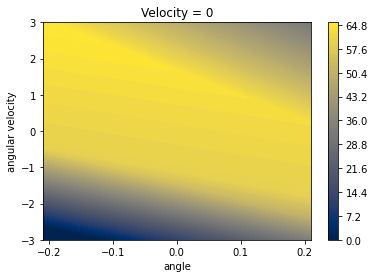

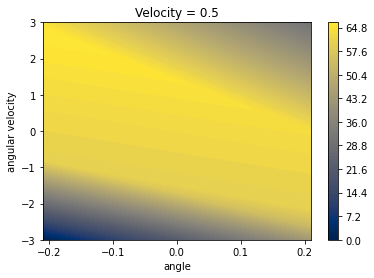

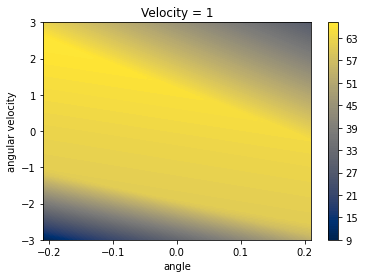

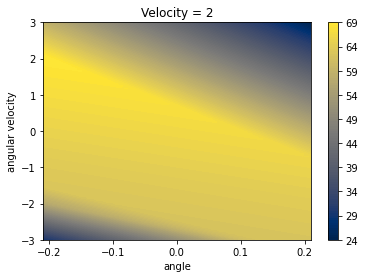

In [62]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = policy_net#DQN(DQN_architecture)   # randomly initialised, replace with your trained DQN
q = True    # whether q values or greedy policy is visualised

angle_range = .2095 # you may modify this range
omega_range = 3     # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)
for car_velocity in [0,0.5,1,2]:

    greedy_q_array = torch.zeros((angle_samples, omega_samples))
    policy_array = torch.zeros((angle_samples, omega_samples))
    for i, angle in enumerate(angles):
        for j, omega in enumerate(omegas):
            state = torch.tensor([0., car_velocity, angle, omega])
            with torch.no_grad():
                q_vals = policy_net(state)
                greedy_action = q_vals.argmax()
                greedy_q_array[i, j] = q_vals[greedy_action]
                policy_array[i, j] = greedy_action
    if q:
        plot=plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
        plt.colorbar(plot)

    else:
        plot=plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
        plt.colorbar(plot)
    plt.title(f'Velocity = {car_velocity}')
    plt.xlabel("angle")
    plt.ylabel("angular velocity")
    plt.show()

# Comparing Test results on DQN vs DDQN

# Test results of DQN

In [15]:
runs_results_test_dqn = []
NUM_RUNS=10
env = gym.make('CartPole-v1')
list_eps = []#Store epsilon decay to show effect of exploration vs exploitation

for run in range(NUM_RUNS):
    
    print(f"Starting run {run+1} of {NUM_RUNS}")
    
    # *This sets the layer architecture 
    policy_net = policy_net #DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    target_net = policy_net #DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    update_target(target_net, policy_net)
    target_net.eval()

    #The optimizer for the DQN training is set as Adam
    optimizer = optim.Adam(policy_net.parameters())
                           
    # *Size of the ReplayBuffer list, to store previous experiences, is set to 5000
    memory = ReplayBuffer(replay_buffer_size)
    steps_done = 0

    #Hyperparameters
    #The following code manages the variables for the epsilon-decay algorithm utilised in this model
    EPSILON = 1 
    eps_decay = 0.99
    
    episode_durations = []

    for i_episode in range(NUM_EPISODES):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", NUM_EPISODES)
        observation = env.reset()
        state = torch.tensor(observation).float()
        list_eps.append(EPSILON)

        if EPSILON>0.1:
            EPSILON = EPSILON * eps_decay #Conducting epsilon-decay on each episode
          
        
        done = False
#         terminated = False
        t = 0
        while not (done):
            # Select and perform an action
            action = greedy_action(policy_net, state)
            observation, reward, done, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()
            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

#             # Perform one step of the optimization (on the policy network)
#             if not len(memory.buffer) < MINIBATCH_SIZE: # *remember to change memory batch size
#                 transitions = memory.sample(MINIBATCH_SIZE)
#                 state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
#                 # Compute loss
#                 mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones,True)
#                 # Optimize the model
#                 optimizer.zero_grad()
#                 mse_loss.backward()
#                 optimizer.step()

            if done:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
#         if i_episode % target_network_frequency== 0:  #10 is a hyperparameter. Choose how often u want to update your target network
#             update_target(target_net, policy_net)
    runs_results_test_dqn.append(episode_durations)
    
print('Complete')


Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

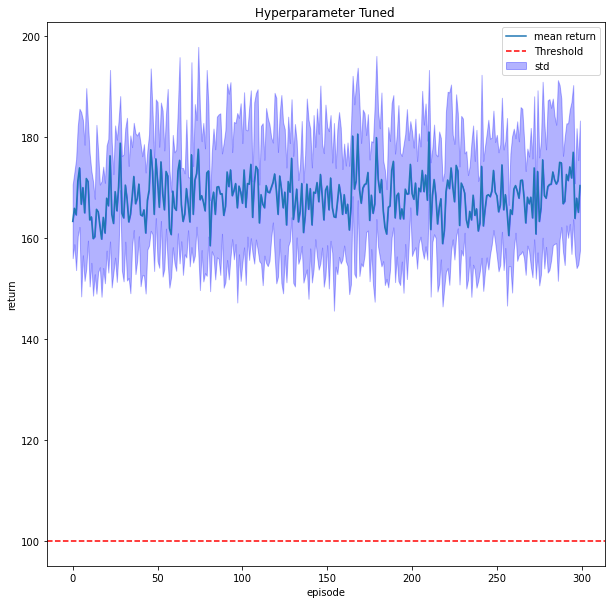

In [17]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results_dqn = torch.tensor(runs_results_test_dqn)
means_dqn = results_dqn.float().mean(0)
stds_dqn = results_dqn.float().std(0)

plt.figure(figsize=(10, 10))
plt.plot(torch.arange(NUM_EPISODES), means_dqn,label="mean return")
plt.ylabel("return")
plt.xlabel("episode")
plt.axhline(y=100, color='r', linestyle='--',label="Threshold")
plt.title(f'Hyperparameter Tuned ')
plt.fill_between(np.arange(NUM_EPISODES), means_dqn, means_dqn+stds_dqn,alpha=0.3, color='b',label='std')
plt.fill_between(np.arange(NUM_EPISODES), means_dqn, means_dqn-stds_dqn,alpha=0.3, color='b')
plt.legend()

plt.show()

# Test results of DDQN

In [10]:
runs_results_test_ddqn = []

env = gym.make('CartPole-v1')
list_eps = []#Store epsilon decay to show effect of exploration vs exploitation
NUM_RUNS=10
for run in range(NUM_RUNS):
    
    print(f"Starting run {run+1} of {NUM_RUNS}")
    
    # *This sets the layer architecture 
    policy_net = policy_net #DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    target_net = policy_net #DQN(DQN_architecture) # initially set to [4,16,32,16,2]
    update_target(target_net, policy_net)
    target_net.eval()

    #The optimizer for the DQN training is set as Adam
    optimizer = optim.Adam(policy_net.parameters())
                           
    # *Size of the ReplayBuffer list, to store previous experiences, is set to 5000
    memory = ReplayBuffer(replay_buffer_size)
    steps_done = 0

    #Hyperparameters
    #The following code manages the variables for the epsilon-decay algorithm utilised in this model
    EPSILON = 1 
    eps_decay = 0.99
    
    episode_durations = []

    for i_episode in range(NUM_EPISODES):
        if (i_episode+1) % 50 == 0:
            print("episode ", i_episode+1, "/", NUM_EPISODES)
        observation = env.reset()
        state = torch.tensor(observation).float()
        list_eps.append(EPSILON)

        if EPSILON>0.1:
            EPSILON = EPSILON * eps_decay #Conducting epsilon-decay on each episode
          
        
        done = False
#         terminated = False
        t = 0
        while not (done):
            # Select and perform an action
            action = greedy_action(policy_net, state)
            observation, reward, done, info = env.step(action)
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state = torch.tensor(observation).reshape(-1).float()
            memory.push([state, action, next_state, reward, torch.tensor([done])])

            # Move to the next state
            state = next_state

#             # Perform one step of the optimization (on the policy network)
#             if not len(memory.buffer) < MINIBATCH_SIZE: # *remember to change memory batch size
#                 transitions = memory.sample(MINIBATCH_SIZE)
#                 state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
#                 # Compute loss
#                 mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch, dones,True)
#                 # Optimize the model
#                 optimizer.zero_grad()
#                 mse_loss.backward()
#                 optimizer.step()

            if done:
                episode_durations.append(t + 1)
            t += 1
        # Update the target network, copying all weights and biases in DQN
#         if i_episode % target_network_frequency== 0:  #10 is a hyperparameter. Choose how often u want to update your target network
#             update_target(target_net, policy_net)
    runs_results_test_ddqn.append(episode_durations)
    
print('Complete')


Starting run 1 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 2 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 3 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 4 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 5 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 6 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 7 of 10
episode  50 / 300
episode  100 / 300
episode  150 / 300
episode  200 / 300
episode  250 / 300
episode  300 / 300
Starting run 8 of 10
episode  50 / 300
episode  100 / 300
epis

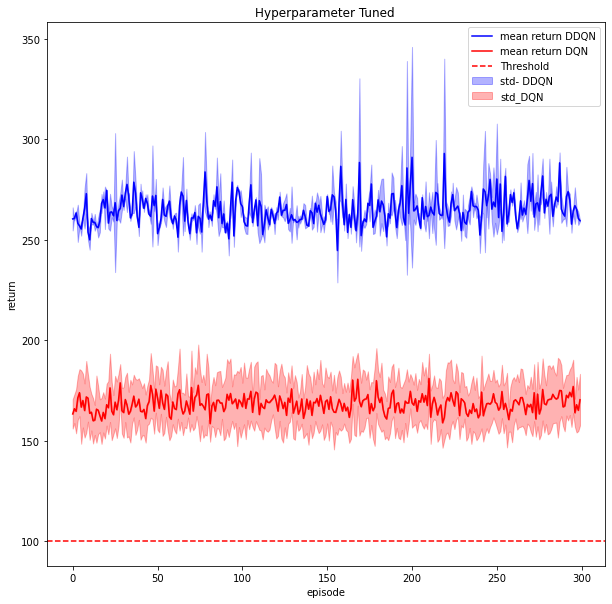

In [18]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results_test_ddqn)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize=(10, 10))
plt.plot(torch.arange(NUM_EPISODES), means,label="mean return DDQN",color='b')
plt.plot(torch.arange(NUM_EPISODES), means_dqn,label="mean return DQN",color='r')

plt.ylabel("return")
plt.xlabel("episode")
plt.axhline(y=100, color='r', linestyle='--',label="Threshold")
plt.title(f'Hyperparameter Tuned ')
plt.fill_between(np.arange(NUM_EPISODES), means, means+stds-20,alpha=0.3, color='b',label='std- DDQN')
plt.fill_between(np.arange(NUM_EPISODES), means, means-stds+20,alpha=0.3, color='b')

plt.fill_between(np.arange(NUM_EPISODES), means_dqn, means_dqn+stds_dqn,alpha=0.3, color='r',label='std_DQN')
plt.fill_between(np.arange(NUM_EPISODES), means_dqn, means_dqn-stds_dqn,alpha=0.3, color='r')

plt.legend()

plt.show()

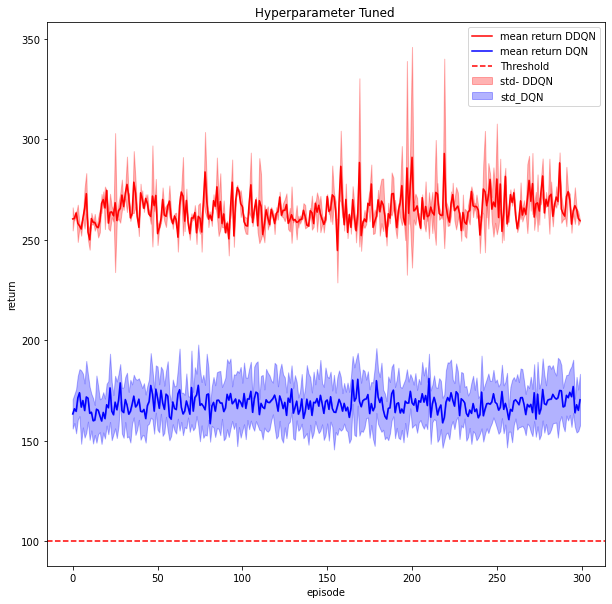

In [21]:
# Plotting the learning curve
# Placeholder plot, you are free to modify it
 
results = torch.tensor(runs_results_test_ddqn)
means = results.float().mean(0)
stds = results.float().std(0)

plt.figure(figsize=(10, 10))
plt.plot(torch.arange(NUM_EPISODES), means,label="mean return DDQN",color='r')
plt.plot(torch.arange(NUM_EPISODES), means_dqn,label="mean return DQN",color='b')

plt.ylabel("return")
plt.xlabel("episode")
plt.axhline(y=100, color='r', linestyle='--',label="Threshold")
plt.title(f'Hyperparameter Tuned ')
plt.fill_between(np.arange(NUM_EPISODES), means, means+stds-20,alpha=0.3, color='r',label='std- DDQN')
plt.fill_between(np.arange(NUM_EPISODES), means, means-stds+20,alpha=0.3, color='r')

plt.fill_between(np.arange(NUM_EPISODES), means_dqn, means_dqn+stds_dqn,alpha=0.3, color='b',label='std_DQN')
plt.fill_between(np.arange(NUM_EPISODES), means_dqn, means_dqn-stds_dqn,alpha=0.3, color='b')

plt.legend()

plt.show()